# Projet 2024 d'Informatique appliquée à la finance, M1 Economie et Finance

# **Partie 1**

## Estimation et test du modèle à 5 facteurs de Fama French (2014)

En Asset Pricing, l'excès de rendement d'une action est décomposé de la façon suivante :

$$
R_{it}-RF_{t} = \alpha_{i} +\sum_{j=1}^{k} \beta_{i}^{j} f_{jt} + e_{it}
$$
où 
- $R_{it}$ est le rendement de l'action *i* à la date *t*,
- $RF_{t}$ est le taux sans risque à la date *t*,
- les $f_{it}, i=1,..,k$ sont *k* facteurs expliquant les variations communes des rendements et le risque non-diversifiable
- le $\beta_{i}^{j},j=1...,k$ est l'exposition de l'actif *i* au facteur $f_{jt}$
- $e_{it}$ est la composante spécifique à l'actif *i* représentant le risque diversifiable avec $E(e_{it})=0$

Si les facteurs sont correctement choisis, c'est-à-dire qu'ils représentent les variations des rendements anticipés, on aura $\alpha_{i}=0$ 

**Fama et French (1993)** (Common risk factors in the returns on stocks and bonds, Journal of Financial Economics, 33 (1) , pp. 3-56) proposent un modèle à trois facteurs afin d'analyser les rendements des actions ou des portefeuilles d'actions. 
Dans le modèle à 3 facteurs, le rendement moyen d'une action est supposé être corrélé avec :

1. le rendement du portefeuille du marché corrigé du taux sans risque : $Mkt-RF$
2. la taille (*Size*) de l'entreprise mesurée par sa capitalisation boursière (nombre d'actions en circulation $\times$ prix d'une action). 
    - Cet effet est mesuré par le facteur $SML_{t}$ égal à la différence de rendement d'un portefeuille de petites entreprises moins celui d'un portefeuille de grandes entreprises.
3. le book to market ratio *B/M* (ratio de la valeur comptable et de la valeur de marché). Une entreprise ayant un ratio B/M elevé sera plutôt sous-évaluée et on s'attend à ce qu'elle ait ura un taux de rendement élevé. 
    - Cet effet est mesuré par le facteur $HML_{t}$ calculé comme la difference de rendements entre des portefeuilles à haut (high)
et faible (Low) ratio B/M

Ces trois facteurs ne permettent pas d'expliquer totalement les variations des rendements anticipés.  **Fama et French (2015)** ('A five-factor asset pricing model', Journal of Financial Economics, 116 1-22) ajoutent deux facteurs supplémentaires prenant en compte : 

4. la profitabilité anticipée des entreprises : des gains anticipés plus élevés ont tendance à augmenter le taux de rendement (toutes choses égales par ailleurs). Le facteur $RMW_{t}$ est la différence de rendement entre un portefeuille d'entreprises à forte (robust) et faible (weak) rentabilité.
5. les investissements anticipés des entreprises : des investissements plus élevés ont tendance à réduire le taux de rendement (moins de dividendes donc une valeur de marché plus petite).  Le facteur $CMA_{t}$ est la différence entre un portefeuille d'entreprises à faible nivea d'investissement (conservative) et d'entreprises à fort niveau d'investissement (agressive)

L'objectif de cette fiche va être d'utiliser ces facteurs pour estimer la décomposition des rendements d'un ensemble de portefeuilles d'action du NYSE, AMEX et Nasdaq.
On vérifiera dans quelle mesure ces facteurs expliquent correctement les rendements anticipés

    
Les données se trouvent sur le site de Kenneth French
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
    
    
**Dans les parties III et IV, les estimations devront être faites sur la période 1963-07-01 à 2023-07-01**


**Vous pouvez ajouter vos réponses (codes, affichage et commentaires des résultats) directement dans le notebook. Vous le sauvergardez avec votre nom.**
    

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from scipy.stats import pearsonr
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
import numpy as np
from scipy.stats import bartlett
import yfinance as yf
from fpdf import FPDF
from tabulate import tabulate
import os
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\odend\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## I. Les 5 facteurs de Fama-French

#### 1. Importation des données 

Les données des facteurs de 5 facteurs de Fama-French sont stockées dans le fichier "F-F_Research_Data_5_Factors_2x3.csv". 

1. Importez les observations mensuelles de ces facteurs à partir de "1963-07-01".
2. Vérifiez l'existence de variables manquantes
3. Après des transformations appropriées, la date deviendra l'indice des données. 
4. Construire un dataframe spécifique pour le taux sans risque.

In [75]:
facteurs = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, nrows=724, header=0)
facteurs.head(5)

# facteurs_annuels=pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", skiprows=729, nrows=60, header=0)
# facteurs_annuels.tail(5)

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1,196308,5.07,-0.80,1.80,0.36,-0.35,0.25
2,196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
3,196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
4,196311,-0.85,-0.88,1.75,-0.51,2.24,0.27


#### 2. Données manquantes



In [76]:
#test données manquantes 
# print(facteurs.isnull().sum())
facteurs = facteurs.dropna()
print(facteurs.isnull().sum())

# print(facteurs_annuels.isnull().sum())


Date      0
Mkt-RF    0
SMB       0
HML       0
RMW       0
CMA       0
RF        0
dtype: int64


#### 3. Formatage des dates + Taux sans risque

1. Transformez les dates en indice du dataframe
2. Stockez le taux sans risque RF dans un dataframe spécifique

In [77]:
#transformation des dates en indice du dataframe
facteurs.index=pd.to_datetime(facteurs["Date"],format="%Y%m")
facteurs=facteurs.drop(columns=["Date"])

In [78]:
facteurs.head(5)

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27


In [79]:
#stockage du taux sans risque dans un dataframe spécifique
rf_mensuel=pd.DataFrame(facteurs["RF"])

#### 4. Représentation graphique des facteurs

Faites la représentation graphique des facteurs 

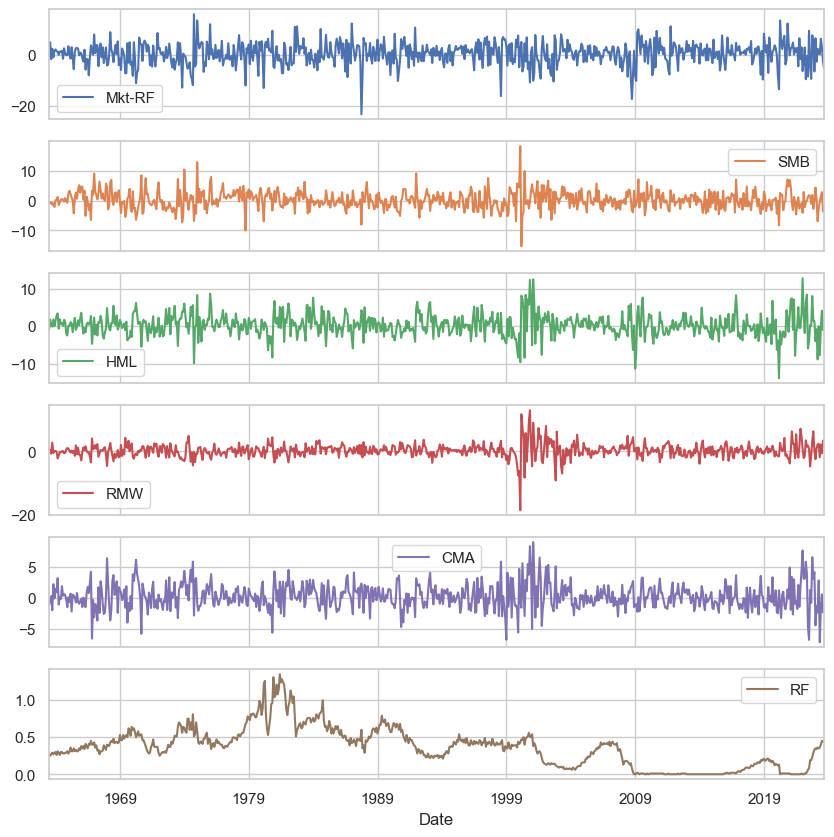

In [80]:
#représentation graphique de chacun des facteurs (sauf date)
facteurs.plot(subplots=True,figsize=(10,10))
plt.show()

Les graphs des facteurs Mkt-RF, SMB, HML, RMW et CMA présentent des fluctuations autour de zéro.
Les séries montrent une volatilité variable selon les périodes, avec des pics marqués autour des crises financières, comme en 2000 et 2008. 

RF se distingue par une tendance décroissante sur le long terme, en ligne avec la baisse des taux directeurs observée depuis les années 1980. On note une stabilisation à des niveaux très bas après 2008, avant une légère reprise dans les périodes récentes.

#### 5. Statistiques descriptives

Calculez la moyenne, le maximum, le minimum, l'écart-type, le skewness, le kurtosis pour chaque facteur

    - pour la totalité de l'échantillon
    - par année
    - par mois

In [81]:
# Totalité de l'échantillon
stats = {
    "moyenne": facteurs.mean(),
    "max": facteurs.max(),
    "min": facteurs.min(),
    "écart-type": facteurs.std(),
    "skewness": facteurs.skew(),
    "kurtosis": facteurs.kurtosis(),
}

#On crée un dataframe pour une meilleure lisibilité
stats_df = pd.DataFrame(stats).round(3)
print(stats_df)


        moyenne    max    min  écart-type  skewness  kurtosis
Mkt-RF    0.556  16.10 -23.24       4.491    -0.499     1.751
SMB       0.211  18.28 -15.32       3.023     0.331     3.065
HML       0.284  12.75 -13.87       2.996     0.075     2.310
RMW       0.291  13.07 -18.65       2.220    -0.273    11.110
CMA       0.274   9.07  -7.22       2.080     0.263     1.461
RF        0.362   1.35   0.00       0.266     0.667     0.691


In [82]:
# Par année : Calculer toutes les statistiques
stats_annuel = facteurs.resample("Y").agg(
    ["mean", "max", "min", "std", "skew", lambda x: x.kurtosis()]
)

# Renommer la colonne kurtosis pour plus de clarté
stats_annuel = stats_annuel.rename(columns={"<lambda_0>": "kurtosis"})

# Arrondir les résultats pour une meilleure lisibilité
stats_annuel = stats_annuel.round(3)

# Affichage du tableau
print(stats_annuel)



           Mkt-RF                                         SMB              \
             mean    max    min    std   skew kurtosis   mean   max   min   
Date                                                                        
1963-12-31  1.103   5.07  -1.57  2.510  0.680   -0.557 -1.017 -0.41 -2.10   
1964-12-31  0.966   2.69  -1.44  1.148 -0.597    0.292  0.032  1.23 -1.52   
1965-12-31  0.839   3.54  -5.51  2.561 -1.423    2.463  1.706  5.19 -4.28   
1966-12-31 -1.098   3.86  -7.91  3.244 -0.751    0.745  0.298  4.71 -6.45   
1967-12-31  1.835   8.15  -4.33  3.473 -0.216    0.068  3.010  9.10 -0.04   
...           ...    ...    ...    ...    ...      ...    ...   ...   ...   
2019-12-31  2.133   8.40  -6.94  4.019 -0.813    1.625 -0.351  3.03 -3.51   
2020-12-31  2.069  13.65 -13.39  7.998 -0.440   -0.168  0.528  7.11 -8.28   
2021-12-31  1.818   6.65  -4.37  2.938 -0.581    0.745 -0.093  6.94 -4.61   
2022-12-31 -1.771   9.57  -9.46  6.698  0.484   -1.146 -0.097  2.92 -4.06   

#### 6. Matrice de correlation
1. Estimez la matrice de corrélation des facteurs et commentez
2. Faites une représentation graphique de cette matrice
3. Vérifiez la significativité de la corrélation entre les facteurs $HML$ et $SMB$

          Mkt-RF       SMB       HML       RMW       CMA        RF
Mkt-RF  1.000000  0.280470 -0.209185 -0.180923 -0.361115 -0.084629
SMB     0.280470  1.000000 -0.014685 -0.352044 -0.093437 -0.035583
HML    -0.209185 -0.014685  1.000000  0.088654  0.686378  0.066941
RMW    -0.180923 -0.352044  0.088654  1.000000 -0.012526 -0.009499
CMA    -0.361115 -0.093437  0.686378 -0.012526  1.000000  0.053965
RF     -0.084629 -0.035583  0.066941 -0.009499  0.053965  1.000000


Text(0.5, 1.0, 'Matrice de corrélation des facteurs')

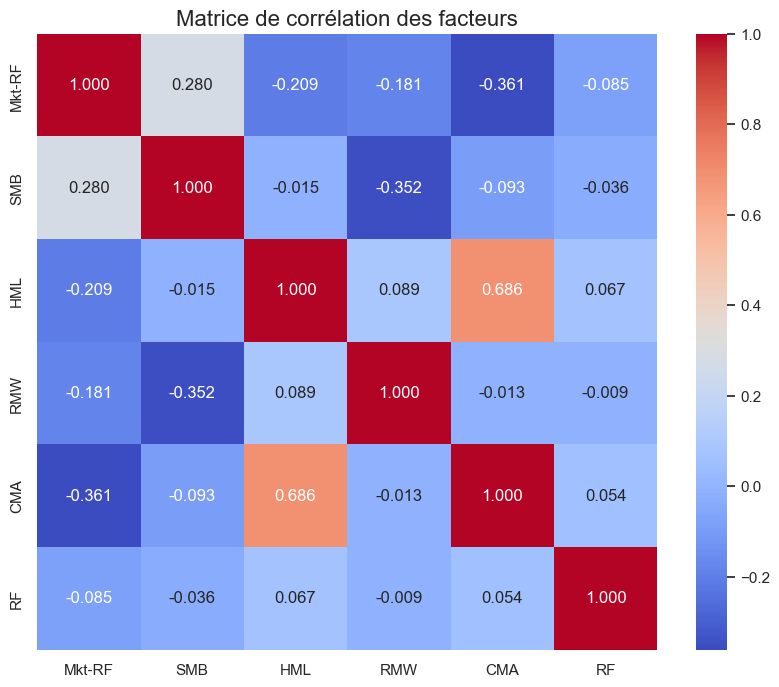

In [83]:
#matrice de correlation des facteurs
correlation=facteurs.corr()
print(correlation)

#représentation graphique avec seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des facteurs", fontsize=16)

Pour tester la significativité de la corrélation entre HML et SMB, on utilise un test statistique basé sur le coefficient de Pearson.

Corrélation significative au seuil de 5% : p-value < 0.05
Corrélation non significative au seuil de 5% : p-value > 0.05

In [84]:
# corrélation et p-value pour HML et SMB
corr, p_value = pearsonr(facteurs['HML'], facteurs['SMB'])

print(f"Corrélation entre HML et SMB : {corr:.3f}")
print(f"P-value : {p_value:.3e}")

# Interprétation
if p_value < 0.05:
    print("La corrélation est statistiquement significative (niveau de confiance de 95%).")
else:
    print("La corrélation n'est pas statistiquement significative.")


Corrélation entre HML et SMB : -0.015
P-value : 6.934e-01
La corrélation n'est pas statistiquement significative.


## II. Les 25 portefeuilles formés à partir de B/M et OP

On importe les rendements de 25 portefeuilles formés à partir des titres du NYSE, de l'AMEX, du NASDAQ pour lesquels on dispose de toutes les quotations. 
Ces actions sont réparties en 25 portefeuilles obtenus par le croisement du ratio *B/M*:
- divisé en 5 catégories LoBM ou BM1/BM2/BM3/BM4/HiBM ou BM5

et de l'Operating Profitability: 
 
- divisé en 5 catégories LoOP ou OP1/OP2/OP3/OP4/HiOP ou OP5

Ces données se trouvent dans le fichier "25_Portfolios_BEME_OP_5x5.CSV"

#### 1. Importation des données

1. Importez les données
2. Transformez les dates au format yyyy-mm-01 (exemple 196307 devient 1963-07-01)
3. Transformez les dates en indices
4. Sélectionnez les observations à partir de "1963-07-01"

In [85]:
#Importation des données
port=pd.read_csv("25_Portfolios_BEME_OP_5x5_Wout_Div.csv", skiprows=21, nrows=723, header=0, encoding="latin1")
port.tail(5)

,Unnamed: 0,LoBM LoOP,BM1 OP2,BM1 OP3,BM1 OP4,LoBM HiOP,BM2 OP1,BM2 OP2,BM2 OP3,BM2 OP4,...,BM4 OP1,BM4 OP2,BM4 OP3,BM4 OP4,BM4 OP5,HiBM LoOP,BM5 OP2,BM5 OP3,BM5 OP4,HiBM HiOP
718,202305,10.0977,6.2492,-1.0759,12.7733,1.4655,9.0146,-2.0100,-1.8815,-3.5716,...,-4.6017,-6.5003,-8.4818,-3.8537,-6.6704,-7.8915,-6.6034,-4.0411,-4.5982,-10.3103
719,202306,5.3849,7.4446,5.3773,8.7382,6.5803,3.2510,6.5592,6.4198,5.2037,...,5.9053,5.9250,5.4416,7.3581,14.3667,10.3101,5.3176,5.9439,3.9588,14.7055
720,202307,4.9171,0.8839,2.3438,3.5863,1.4706,6.9145,1.8782,4.1941,7.1681,...,5.8377,4.1496,8.6121,5.3051,8.2419,7.5916,7.6837,7.3940,7.2865,9.3661
721,202308,-5.8210,-1.4650,1.2550,-1.2892,-1.2077,-7.8681,-3.4998,-1.2129,-0.1090,...,-0.8029,-4.5673,-7.3989,-1.9368,1.1065,-7.0768,-6.0328,-7.8446,-4.8547,2.5567
722,202309,-5.0326,-4.3711,-7.3260,-5.0557,-5.7225,-5.8245,-5.7649,-4.8949,-4.3193,...,-3.6377,-4.5404,-2.9789,-2.4203,0.9534,-7.8518,-2.3593,-3.6544,-2.7802,-4.7522


In [86]:
#test données manquantes 
print(port.isnull().sum())
port = port.dropna()
print(port.isnull().sum())

Unnamed: 0    0
LoBM LoOP     0
BM1 OP2       0
BM1 OP3       0
BM1 OP4       0
LoBM HiOP     0
BM2 OP1       0
BM2 OP2       0
BM2 OP3       0
BM2 OP4       0
BM2 OP5       0
BM3 OP1       0
BM3 OP2       0
BM3 OP3       0
BM3 OP4       0
BM3 OP5       0
BM4 OP1       0
BM4 OP2       0
BM4 OP3       0
BM4 OP4       0
BM4 OP5       0
HiBM LoOP     0
BM5 OP2       0
BM5 OP3       0
BM5 OP4       0
HiBM HiOP     0
dtype: int64
Unnamed: 0    0
LoBM LoOP     0
BM1 OP2       0
BM1 OP3       0
BM1 OP4       0
LoBM HiOP     0
BM2 OP1       0
BM2 OP2       0
BM2 OP3       0
BM2 OP4       0
BM2 OP5       0
BM3 OP1       0
BM3 OP2       0
BM3 OP3       0
BM3 OP4       0
BM3 OP5       0
BM4 OP1       0
BM4 OP2       0
BM4 OP3       0
BM4 OP4       0
BM4 OP5       0
HiBM LoOP     0
BM5 OP2       0
BM5 OP3       0
BM5 OP4       0
HiBM HiOP     0
dtype: int64


In [87]:
port['Unnamed: 0'] = pd.to_datetime(port['Unnamed: 0'], format='%Y%m')
port.set_index('Unnamed: 0', inplace=True)
port.tail(5)

,LoBM LoOP,BM1 OP2,BM1 OP3,BM1 OP4,LoBM HiOP,BM2 OP1,BM2 OP2,BM2 OP3,BM2 OP4,BM2 OP5,...,BM4 OP1,BM4 OP2,BM4 OP3,BM4 OP4,BM4 OP5,HiBM LoOP,BM5 OP2,BM5 OP3,BM5 OP4,HiBM HiOP
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2023-05-01,10.0977,6.2492,-1.0759,12.7733,1.4655,9.0146,-2.0100,-1.8815,-3.5716,-0.4939,...,-4.6017,-6.5003,-8.4818,-3.8537,-6.6704,-7.8915,-6.6034,-4.0411,-4.5982,-10.3103
2023-06-01,5.3849,7.4446,5.3773,8.7382,6.5803,3.2510,6.5592,6.4198,5.2037,8.5788,...,5.9053,5.9250,5.4416,7.3581,14.3667,10.3101,5.3176,5.9439,3.9588,14.7055
2023-07-01,4.9171,0.8839,2.3438,3.5863,1.4706,6.9145,1.8782,4.1941,7.1681,7.4255,...,5.8377,4.1496,8.6121,5.3051,8.2419,7.5916,7.6837,7.3940,7.2865,9.3661
2023-08-01,-5.8210,-1.4650,1.2550,-1.2892,-1.2077,-7.8681,-3.4998,-1.2129,-0.1090,-2.7447,...,-0.8029,-4.5673,-7.3989,-1.9368,1.1065,-7.0768,-6.0328,-7.8446,-4.8547,2.5567
2023-09-01,-5.0326,-4.3711,-7.3260,-5.0557,-5.7225,-5.8245,-5.7649,-4.8949,-4.3193,-2.5609,...,-3.6377,-4.5404,-2.9789,-2.4203,0.9534,-7.8518,-2.3593,-3.6544,-2.7802,-4.7522


#### 2. Calculez les excès de rendements $R_{it} -RF_{t}$

In [88]:
#crée un nouveau dataframe avec les rendements des portefeuilles auquel on soustrait le taux sans risque
port_exces = port.sub(rf_mensuel['RF'], axis=0)
port_exces.tail(5)

,LoBM LoOP,BM1 OP2,BM1 OP3,BM1 OP4,LoBM HiOP,BM2 OP1,BM2 OP2,BM2 OP3,BM2 OP4,BM2 OP5,...,BM4 OP1,BM4 OP2,BM4 OP3,BM4 OP4,BM4 OP5,HiBM LoOP,BM5 OP2,BM5 OP3,BM5 OP4,HiBM HiOP
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2023-05-01,9.7377,5.8892,-1.4359,12.4133,1.1055,8.6546,-2.3700,-2.2415,-3.9316,-0.8539,...,-4.9617,-6.8603,-8.8418,-4.2137,-7.0304,-8.2515,-6.9634,-4.4011,-4.9582,-10.6703
2023-06-01,4.9849,7.0446,4.9773,8.3382,6.1803,2.8510,6.1592,6.0198,4.8037,8.1788,...,5.5053,5.5250,5.0416,6.9581,13.9667,9.9101,4.9176,5.5439,3.5588,14.3055
2023-07-01,4.4671,0.4339,1.8938,3.1363,1.0206,6.4645,1.4282,3.7441,6.7181,6.9755,...,5.3877,3.6996,8.1621,4.8551,7.7919,7.1416,7.2337,6.9440,6.8365,8.9161
2023-08-01,-6.2710,-1.9150,0.8050,-1.7392,-1.6577,-8.3181,-3.9498,-1.6629,-0.5590,-3.1947,...,-1.2529,-5.0173,-7.8489,-2.3868,0.6565,-7.5268,-6.4828,-8.2946,-5.3047,2.1067
2023-09-01,-5.4626,-4.8011,-7.7560,-5.4857,-6.1525,-6.2545,-6.1949,-5.3249,-4.7493,-2.9909,...,-4.0677,-4.9704,-3.4089,-2.8503,0.5234,-8.2818,-2.7893,-4.0844,-3.2102,-5.1822


#### 3. Calcul de statistiques descriptives

Calculez les rendements moyens pour chaque portefeuille. Que pouvez-vous dire de la relation entre le rendement moyen et 
- le *B/M* (*value effect*)  ?
- le *OP* (*profitability effect*) ?

In [89]:
#calcul rendement moyen pour chaque portefeuille
rend_moyen = port_exces.mean()
rend_moyen

LoBM LoOP    0.107134
BM1 OP2      0.489720
BM1 OP3      0.397750
BM1 OP4      0.400759
LoBM HiOP    0.449978
BM2 OP1      0.195108
BM2 OP2      0.289117
BM2 OP3      0.393034
BM2 OP4      0.386393
BM2 OP5      0.397535
BM3 OP1      0.097660
BM3 OP2      0.281477
BM3 OP3      0.323598
BM3 OP4      0.510650
BM3 OP5      0.597485
BM4 OP1      0.238857
BM4 OP2      0.274909
BM4 OP3      0.445377
BM4 OP4      0.429359
BM4 OP5      0.713563
HiBM LoOP    0.478896
BM5 OP2      0.485450
BM5 OP3      0.610124
BM5 OP4      0.699663
HiBM HiOP    0.666983
dtype: float64

Sur toutes les séries exceptée BM1, on observe que le rendement moyen augmente avec OP. On suppose une corrélation positive entre OP et le rendement moyen, illustrant l'effet de l'Operating Profitability.
On a également HiBM HiOP > LoBM HiOP et HiBM LoOP > LoBM LoOP. On suppose une corrélation positive entre BM et le rendement moyen, illustrant l'effet du Book/Market ratio.

## III. Estimation du modèle à facteurs


Pour chaque actif *i*, on dispose de T observations ${r_{i1},...,r_{iT}}$. On peut estimer les trois régressions suivantes : :
    
### Régression sur le facteur du marché
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+e_{it}$$

### Régression sur les 3 facteurs
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+s_{i}SMB_{t}+h_{i}HML_{t}+e_{it}$$

### Régression sur les 5 facteurs 
$$ R_{it} - R_{Ft} = \alpha_{i}+\beta_{i}(R_{MT}-R_{Ft})+s_{i}SMB_{t}+h_{i}HML_{t}+r_{i}RMW_{t}+c_{i}CMA_{t}+e_{it}$$

- $R_{Ft}$ est le taux sans risque
- $R_{MT}$ est le taux de rendement du portefeuille du marché
- Le résidu $e_{it}$ représente le risque idiosyncratique (ou risque diversifiable) de chaque actif.
- $\beta_{i}, s_{i}, h_{i},r_{i}, c_{i}$ représentent les expositions à chacun des facteurs
- $\alpha_{i}$ est la constante. Selon la théorie des portefeuilles efficients, on s'attend à avoir $a_{i}=0$. Cette hypothèse peut aussi se justifier par la proposition que l'ensemble des facteurs représentent la totalité des facteurs de risque.

#### 1. Construisez une fonction permettant d'estimer ces trois régressions. Vous conserverez comme output :

1. les coefficients estimés
2. les tstat des coefficients estimés
3. les résidus des régressions
4. La moyenne des constantes en valeur absolue

In [90]:
def regression(a, y, facteurs):
    coefficients = []
    t_stats = []
    residus = []
    constantes = []

    #format
    a = int(a)

    if a == 1:
        x = facteurs[["Mkt-RF"]]
    elif a == 3:
        x = facteurs[["Mkt-RF", "SMB", "HML"]]
    elif a == 5:
        x = facteurs[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]
    else:
        raise ValueError("Réponse invalide. Choisir 1, 2, ou 3.")

    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()

    coefficients.append(model.params)
    t_stats.append(model.tvalues)
    residus.append(model.resid)
    constantes.append(abs(model.params["const"]))

    moyenne_constantes = np.mean(constantes)

    return {
        "coefficients": coefficients,
        "t_stats": t_stats,
        "residus": residus,
        "moyenne_constantes": moyenne_constantes
}

#ici on crée une loop permettant à l'utilisateur de choisir quel modele de régression il souhaite utiliser
a = input("Régression sur le facteur de marché : 1, Régression sur les 3 facteurs : 3, Régression sur les 5 facteurs : 5")
while a != "1" and a != "2" and a != "3":
    a = input("Réponse invalide. Choisir 1 (facteur de marché), 3 (3facteurs), ou 5 (5 facteurs).")

#on teste notre fonction en loopant sur tous les portefeuilles
for i in range(0, len(port_exces.columns)):
        print(f"Portefeuille {i + 1}")
        result = regression(a, port_exces.iloc[:, i], facteurs)
        print(result)

Portefeuille 1
{'coefficients': [const    -0.455387
Mkt-RF    1.210678
SMB       0.596762
HML      -0.834064
dtype: float64], 't_stats': [const     -3.167916
Mkt-RF    35.997720
SMB       12.213961
HML      -17.230798
dtype: float64], 'residus': [Date
1963-07-01    1.355482
1963-08-01    1.917075
1963-09-01   -2.554204
1963-10-01   -4.630936
1963-11-01    0.026227
                ...   
2023-05-01    3.557142
2023-06-01   -3.397210
2023-07-01    2.757478
2023-08-01   -1.628021
2023-09-01    3.672722
Length: 723, dtype: float64], 'moyenne_constantes': 0.45538747722635703}
Portefeuille 2
{'coefficients': [const    -0.053914
Mkt-RF    1.167154
SMB       0.191155
HML      -0.513273
dtype: float64], 't_stats': [const     -0.431487
Mkt-RF    39.925086
SMB        4.501047
HML      -12.199032
dtype: float64], 'residus': [Date
1963-07-01    2.175703
1963-08-01   -3.132042
1963-09-01   -2.915328
1963-10-01   -6.728707
1963-11-01    0.974839
                ...   
2023-05-01    1.644783
2023-06-0

#### 2. Commentaires des estimations 
1. Calculez et donnez les noms des portefeuilles pour lesquels le coefficients du rendement du portefeuille du marché est

- supérieur à 1
- égal à 1
- inférieur à 1
     

In [91]:
#variables pour stocker les résultats
sup_1 = []
inf_1 = []
egal_1 = []

#type de modèle choisi
a=input("Régression sur le facteur de marché : 1, Régression sur les 3 facteurs : 3, Régression sur les 5 facteurs : 5")
while a != "1" and a != "2" and a != "3":
    a = input("Réponse invalide. Choisir 1 (facteur de marché), 3 (3facteurs), ou 5 (5 facteurs).")

#loop sur tous les portefeuilles
for i in range(len(port_exces.columns)):
    result = regression(a, port_exces.iloc[:, i], facteurs)
    
    #on isole le coef du marché
    coef_mkt_rf = result["coefficients"][0]["Mkt-RF"]
    portefeuille = f"Portefeuille {i + 1} : {port_exces.columns[i]}"
    
    #on assigne le portefeuille à la liste correspondante
    if coef_mkt_rf > 1:
        sup_1.append(portefeuille)
    elif coef_mkt_rf < 1:
        inf_1.append(portefeuille)
    elif coef_mkt_rf == 1:
        egal_1.append(portefeuille)

# affichage
print("Portefeuilles avec coefficient > 1:")
print(sup_1)

print("\nPortefeuilles avec coefficient < 1:")
print(inf_1)

print("\nPortefeuilles avec coefficient = 1:")
print(egal_1)


Portefeuilles avec coefficient > 1:
['Portefeuille 1 : LoBM LoOP', 'Portefeuille 2 : BM1 OP2', 'Portefeuille 3 : BM1 OP3', 'Portefeuille 4 : BM1 OP4', 'Portefeuille 6 : BM2 OP1', 'Portefeuille 8 : BM2 OP3', 'Portefeuille 11 : BM3 OP1', 'Portefeuille 15 : BM3 OP5', 'Portefeuille 16 : BM4 OP1', 'Portefeuille 19 : BM4 OP4', 'Portefeuille 20 : BM4 OP5', 'Portefeuille 21 : HiBM LoOP', 'Portefeuille 22 : BM5 OP2', 'Portefeuille 23 : BM5 OP3', 'Portefeuille 24 : BM5 OP4', 'Portefeuille 25 : HiBM HiOP']

Portefeuilles avec coefficient < 1:
['Portefeuille 5 : LoBM HiOP', 'Portefeuille 7 : BM2 OP2', 'Portefeuille 9 : BM2 OP4', 'Portefeuille 10 : BM2 OP5', 'Portefeuille 12 : BM3 OP2', 'Portefeuille 13 : BM3 OP3', 'Portefeuille 14 : BM3 OP4', 'Portefeuille 17 : BM4 OP2', 'Portefeuille 18 : BM4 OP3']

Portefeuilles avec coefficient = 1:
[]


2. Pour chacun des facteurs HML, SMB et CMA, donnez :
    
- le nombre d'actifs pour lesquels chacun des facteurs pris un à un n'est pas significatif
- les noms des portefeuilles concernés

Quels facteurs vous paraissent ne pas avoir un pouvoir explicatif dans les variations des rendements ?

In [92]:
# variables pour stocker les résultats
non_significatif = []
significatif = []

# liste des facteurs à tester
facteurs_test = ["HML", "SMB", "CMA"]

# boucle sur chaque facteur
for j in range(len(facteurs_test)):
    # boucle sur tous les portefeuilles
    for i in range(len(port_exces.columns)):
        # exécute la régression pour le portefeuille i
        result = regression(5, port_exces.iloc[:, i], facteurs)

        # vérifie que t_stats est présent dans le résultat
        if "t_stats" not in result:
            raise KeyError("La clé 't_stats' est absente des résultats de la régression.")

        # vérifie que le facteur testé est dans 't_stats'
        if facteurs_test[j] not in result["t_stats"][0]:
            print(f"Le facteur {facteurs_test[j]} est absent des t-stats pour le portefeuille {port_exces.columns[i]}.")
            continue  # port suivant

        # extraction de la t-stat pour le facteur testé
        t_value = result["t_stats"][0][facteurs_test[j]]

        # conversion de la t-stat en p-value
        p_value = 2 * (1 - t.cdf(abs(t_value), df=len(port_exces) - 1))

        # recuperation du nom du portefeuille
        portefeuille = f"Portefeuille {i + 1} : {port_exces.columns[i]}"

        # ajout le portefeuille à la liste correspondante
        if p_value > 0.05:
            non_significatif.append(portefeuille)
        else:
            significatif.append(portefeuille)

    # affichage des résultats pour le facteur testé
    print(f"\nPortefeuilles pour lesquels {facteurs_test[j]} n'est pas significatif :")
    if non_significatif:
        print("\n".join(non_significatif))
    else:
        print("Aucun portefeuille.")

    print(f"\nPortefeuilles pour lesquels {facteurs_test[j]} est significatif :")
    if significatif:
        print("\n".join(significatif))
    else:
        print("Aucun portefeuille.")

    # reinitialisation des listes
    non_significatif = []
    significatif = []


Portefeuilles pour lesquels HML n'est pas significatif :
Portefeuille 8 : BM2 OP3

Portefeuilles pour lesquels HML est significatif :
Portefeuille 1 : LoBM LoOP
Portefeuille 2 : BM1 OP2
Portefeuille 3 : BM1 OP3
Portefeuille 4 : BM1 OP4
Portefeuille 5 : LoBM HiOP
Portefeuille 6 : BM2 OP1
Portefeuille 7 : BM2 OP2
Portefeuille 9 : BM2 OP4
Portefeuille 10 : BM2 OP5
Portefeuille 11 : BM3 OP1
Portefeuille 12 : BM3 OP2
Portefeuille 13 : BM3 OP3
Portefeuille 14 : BM3 OP4
Portefeuille 15 : BM3 OP5
Portefeuille 16 : BM4 OP1
Portefeuille 17 : BM4 OP2
Portefeuille 18 : BM4 OP3
Portefeuille 19 : BM4 OP4
Portefeuille 20 : BM4 OP5
Portefeuille 21 : HiBM LoOP
Portefeuille 22 : BM5 OP2
Portefeuille 23 : BM5 OP3
Portefeuille 24 : BM5 OP4
Portefeuille 25 : HiBM HiOP

Portefeuilles pour lesquels SMB n'est pas significatif :
Portefeuille 7 : BM2 OP2
Portefeuille 8 : BM2 OP3
Portefeuille 9 : BM2 OP4
Portefeuille 12 : BM3 OP2
Portefeuille 13 : BM3 OP3

Portefeuilles pour lesquels SMB est significatif :
Port

On observe que lML est un facteur significatif sur 24 des 25 portefeuilles. Il est fortement explicatif.
Le coefficient de SMB est significatif sur 20 des 25 portefeuilles. C'est un facteur fortement explicatif.
le coefficient de CMA n'est significatif que dans 12 cas sur 25. Parmi les trois facteurs observés, il semble avoir le pouvoir explicatif le plus faible pour décrire les variations des rendements.

#### 3. Corrélation des résidus

1. Calculez la matrice de corrélation des résidus et faites sa visualisation graphique
2. Peut-on supposer que les corrélations des résidus sont nulles en moyenne ? Que pouvez-vous en déduire sur la capacité des cinq facteurs à expliquer les variations communes des rendements ?


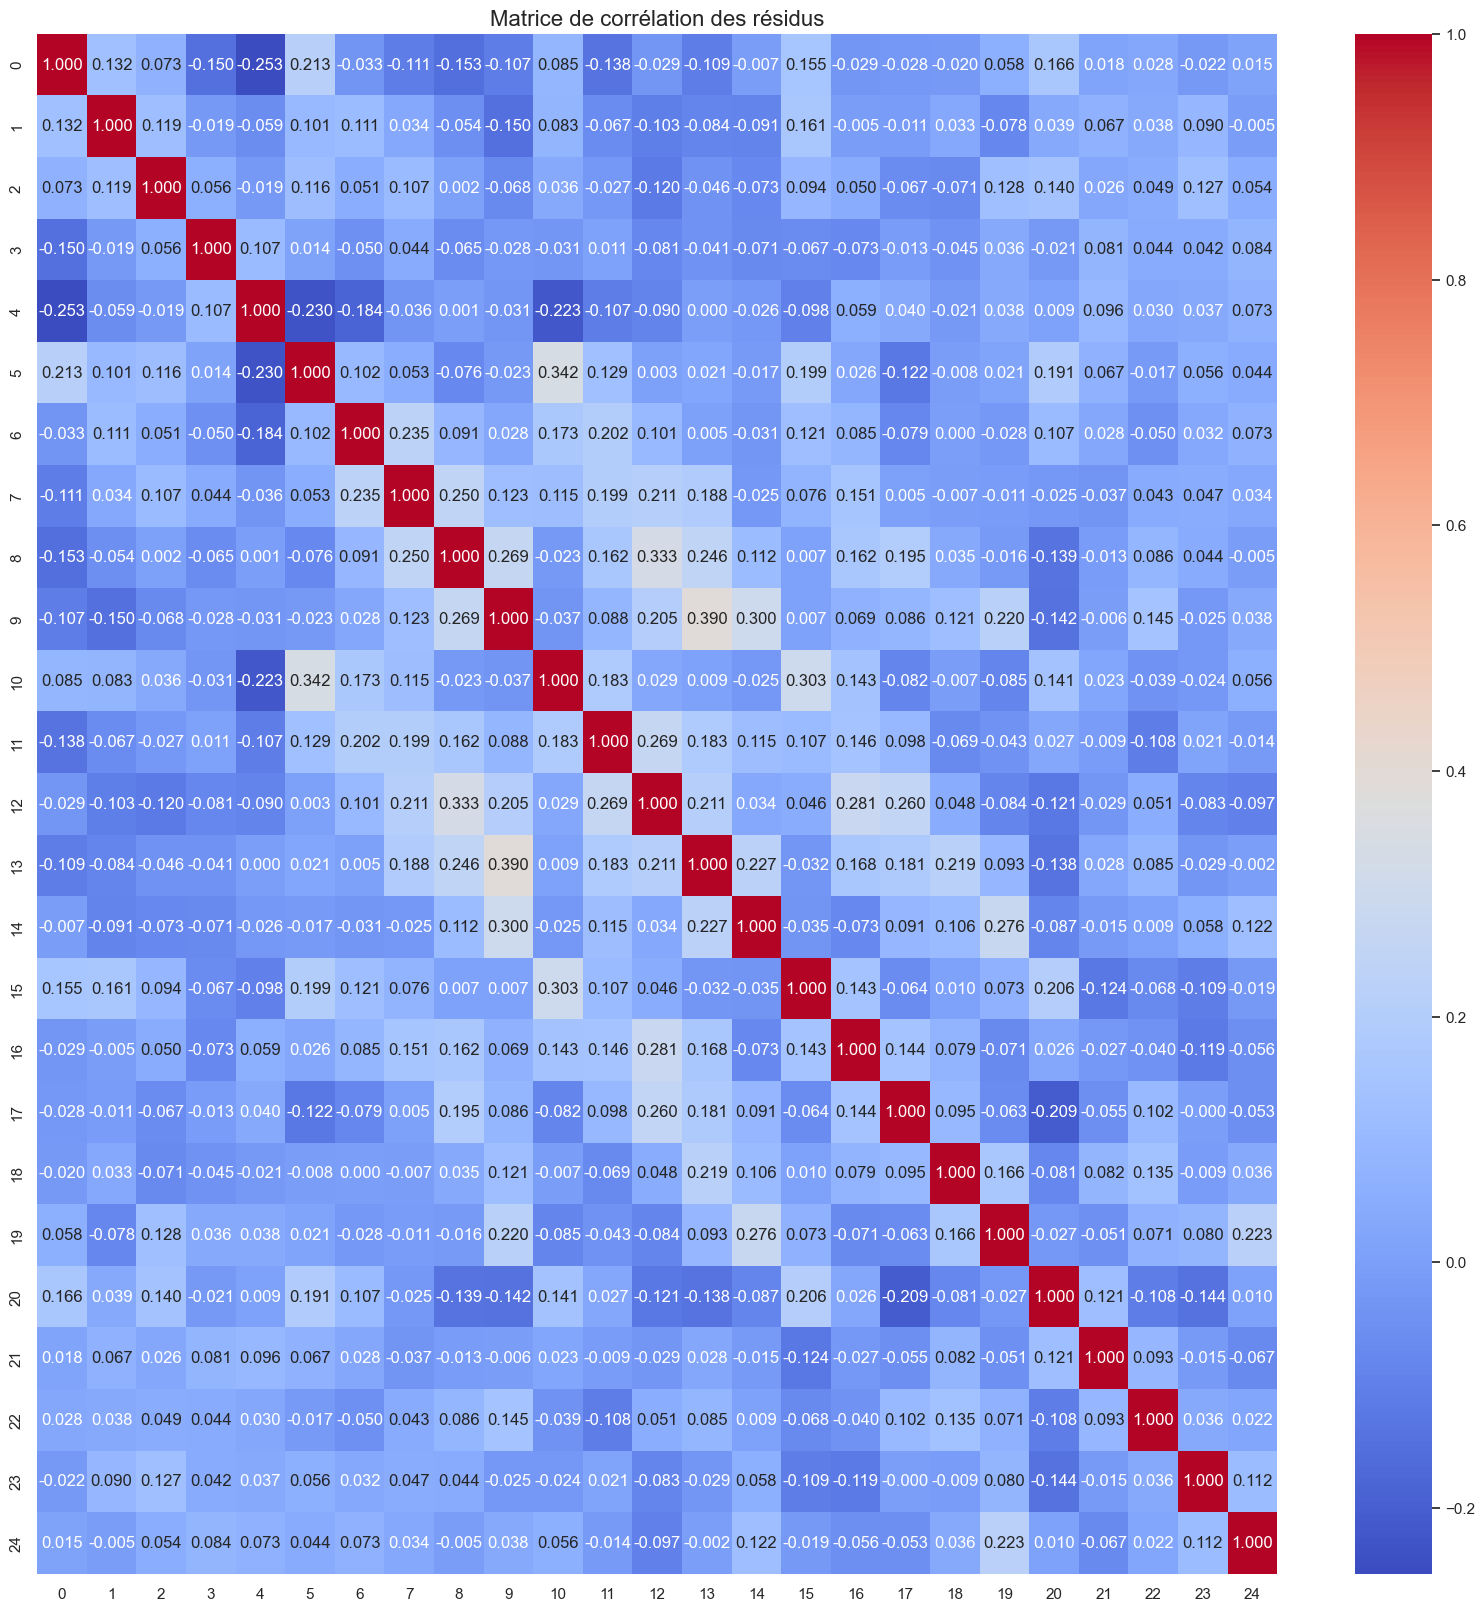

Statistiques descriptives des corrélations des résidus :
{'mean': 0.03198757760468363, 'median': 0.02444864361633641, 'q1': -0.0337354621409348, 'q3': 0.09550296467379704, 'std': 0.10639911239772044, 'min': -0.25341449515591075, 'max': 0.39045271898983697}


In [93]:
#calculez la matrice de correlation des residus et faites sa visualisation graphique
residus = []
for i in range(len(port_exces.columns)):
    result = regression(3, port_exces.iloc[:, i], facteurs)
    residus.append(result["residus"][0])

residus = pd.DataFrame(residus).T
correlation_residus = residus.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_residus, annot=True, fmt=".3f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des résidus", fontsize=16)
plt.show()

#on extrait la diagonale (qui biaise les correlations)
correlation_flat = correlation_residus.values[np.triu_indices_from(correlation_residus, k=1)]

# stats descriptives
stats_descriptives = {
    "mean": np.mean(correlation_flat),
    "median": np.median(correlation_flat),
    "q1":np.percentile(correlation_flat, 25),
    "q3":np.percentile(correlation_flat, 75),
    "std": np.std(correlation_flat),
    "min": np.min(correlation_flat),
    "max": np.max(correlation_flat),
}
print("Statistiques descriptives des corrélations des résidus :")
print(stats_descriptives)

Si les facteurs expliquaient parfaitement les variations communes des rendements, les résidus seraient très faiblement corrélés et (corrélations proches de 0).

On observe néanmoins que les corrélations entre les résidus sont parfois importantes. En effet près de 25% des correlations sont supérieurs à 0.01 (q3=0.098). Il existe aussi une corrélation supérieure à 0.3 en valeur absolue.

Empiriquement, on suppose donc que les 5 facteurs ne parviennent pas à expliquer complètement les variations communes des rendements. Il existe probablement des variations non capturées par le modèle, possiblement dues à des facteurs manquants ou à des dépendances structurelles des portefeuilles. 

Afin d'en avoir le coeur net, on procède à un test de Bartlett sur la matrice de corrélation des residus.

In [94]:
# on extrait les résidus sous forme d'un df
residus_df = pd.DataFrame(residus).T

# calcul du test de Bartlett pour vérifier la nullité des corrélations
chi2, p_value = bartlett(*residus_df.values.T)

print("Test de Bartlett pour la matrice de corrélation des résidus :")
print(f"Chi2 = {chi2:.2f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("Les corrélations des résidus ne sont pas nulles (p < 0.05).")
else:
    print("Les corrélations des résidus sont nulles (p >= 0.05).")

Test de Bartlett pour la matrice de corrélation des résidus :
Chi2 = 4410.72, p-value = 0.0000
Les corrélations des résidus ne sont pas nulles (p < 0.05).


Le test de Bartlett confirme notre intuition empirique. Les corrélations des résidus ne sont pas nulles. Les 5 facteurs ne parviennent pas à expliquer complètement les variations communes des rendements. Il existe  des variations non capturées par le modèle, possiblement dues à des facteurs manquants ou à des dépendances structurelles des portefeuilles.

#### 4. Affichez et commentez les moyennes des $\vert \alpha_{i} \vert$

Moyenne des constantes régression facteur de marché:  0.18795268378133162
Moyenne des constantes régression 3 facteurs:  0.2723091483914516
Moyenne des constantes régression 5 facteurs:  0.2801210370845236


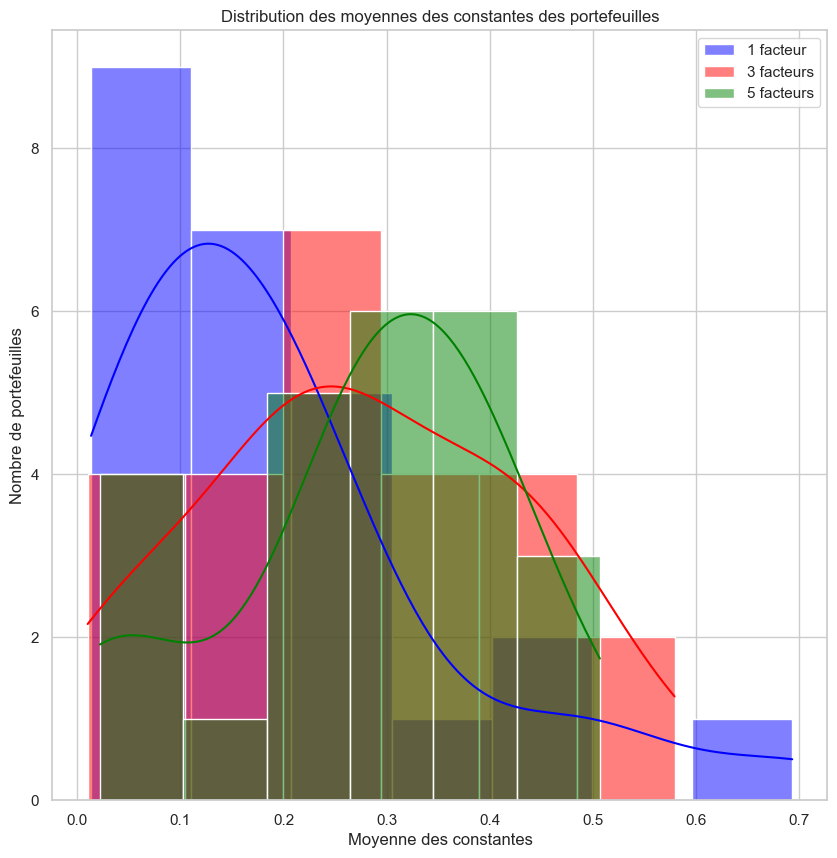

In [95]:
#on crée une liste par type de regression
moyenne_constantes_1 = []
moyenne_constantes_2 = []
moyenne_constantes_3 = []

#loop sur tous les portefeuilles
for i in range(len(port_exces.columns)):
    result_1 = regression(1, port_exces.iloc[:, i], facteurs)
    result_2 = regression(3, port_exces.iloc[:, i], facteurs)
    result_3 = regression(5, port_exces.iloc[:, i], facteurs)
    
    moyenne_constantes_1.append(result_1["moyenne_constantes"])
    moyenne_constantes_2.append(result_2["moyenne_constantes"])
    moyenne_constantes_3.append(result_3["moyenne_constantes"])

#on crée des séries
moyenne_constantes_1 = pd.Series(moyenne_constantes_1)
print("Moyenne des constantes régression facteur de marché: ", moyenne_constantes_1.mean())
moyenne_constantes_2 = pd.Series(moyenne_constantes_2)
print("Moyenne des constantes régression 3 facteurs: ", moyenne_constantes_2.mean())
moyenne_constantes_3 = pd.Series(moyenne_constantes_3)
print("Moyenne des constantes régression 5 facteurs: ", moyenne_constantes_3.mean())

#on crée un histogramme représentatif
plt.figure(figsize=(10, 10))
sns.histplot(moyenne_constantes_1, kde=True, color="blue", label="1 facteur")
sns.histplot(moyenne_constantes_2, kde=True, color="red", label="3 facteurs")
sns.histplot(moyenne_constantes_3, kde=True, color="green", label="5 facteurs")
plt.xlabel("Moyenne des constantes")
plt.ylabel("Nombre de portefeuilles")
plt.title("Distribution des moyennes des constantes des portefeuilles")
plt.legend()
plt.show()

La constante d'une régression représente la partie de la variable dépendante qui ne peut pas être expliquée par les facteurs du modèle. Dans notre contexte, c'est une approximation du rendement excédentaire sur le risk-free rate non expliqué par les variables de chacun des modèles.

Le modèle à 1 facteur (facteur de marché) a une moyenne des constantes de 0,1879.

L’introduction des facteurs SMB et HML dans le modèle à 3 facteurs augmente signgificativement la moyenne des constantes qui passe à 0,2723.

L’ajout des facteurs RMW et CMA dans le modèle à 5 facteurs n’apporte qu’une augmentation limitée, avec une moyenne des constantes légèrement supérieure (0,2801).

Cette augmentation des constantes moyennes entre les modèles (de 1 à 3 à 5 facteurs) peut indiquer que l’ajout de nouveaux facteurs ne réduit pas la part inexpliquée. Cela pourrait signifier que les nouveaux facteurs introduits (notamment RMW et CMA) ne sont pas pertinents ou qu’ils ne capturent pas efficacement les variations spécifiques des rendements des portefeuilles étudiés.

# Partie 2

## Implémentation de stratégies d'analyse technique
### Data:

Trump-Tweets_2009-2021.csv

Data_Trading_Strategies.xlsx



### Stratégies
- SMA
- Momentum
- Mean Reversion (bonus)
- Sentiment analysis appliquée aux tweets de Trump

Il s'agit dans cette partie de construire différentes stratégies (avec signaux d'achat et vente) et de les comparer à un benchmark passif pour savoir si notre stratégie active peut nous permettre de sécuriser un meilleur rendement.

Une stratégie passive: $\$10.000.000$ investis dans le SP500

Il suffit de calculer le rendement d'une date de départ et une date de fin.

Une stratégie active : $\$5.000.000$ investis dans le SP500, $\$5.000.000$ de cash avec des signaux d'achat et vente. 

Attention, vous n'avez pas une liquidité infinie, il est donc impossible d'acheter à l'infini. Idem, pas de vente à découvert infinie (max 50 pourcents de votre capital, cela signifie que vous ne pouvez pas avoir plus de $\$10.000.000$ cash et l'équivalent de $\$5.000.000$ short du SP500). Vous pouvez aussi vous simplifier la tache et interdire la vente à découvert.

Il suffit de calculer le rendement de la stratégie d'une date de départ et une date de fin, en prenant en compte les opérations d'achat vente de la stratégie.

Une stratégie est donc une fonction. A vous de gérer le découpage en fonctions de vos stratégies, de la gestion de vos achats/ventes, de votre capital/investissement, du profit/perte...

### Evaluation: 
Cette partie du projet est beaucoup moins guidée. Vous êtes libres de vous procurer d'autres données. A vous de gérer votre investissement dans cette partie. En effet, cette partie peut être très chronophage: à vous de faire votre arbitrage.

La note de cette partie sera donnée en fonction de ce qu'ont fait les autres groupes

## I. Data management
- Extraction des données dans un ou plusieurs dataframes, nettoyage des données de sorte qu'elles soient facilement utilisables.

- Avec Yahoo finance (ou autre) récupérez un taux sans risque (annualisé par exemple). 

## II. Trading strategies
### 1. Simple Moving Average (SMA)
La stratégie de croisement des moyennes mobiles consiste à calculer deux (ou plus) moyennes mobiles pour le prix d'un actif : une moyenne mobile à court terme (appelée SMA rapide) et une moyenne mobile à long terme (SMA lente). Vous pouvez, par exemple comparer la SMA 7 jours vs 30 jours: achat si la moyenne mobile courte coupe à la hausse la moyenne mobile longue,
vente si la moyenne mobile courte coupe à la baisse la moyenne mobile longue.


### 2. Momentum
Cette stratégie est basée sur le nombre de fois qu'un prix augmente ou diminue. Elle part du principe que lorsqu'un prix augmente pendant un certain nombre de jours consécutifs, c'est un signal d'achat, et lorsqu'il diminue, c'est un signal de vente.

### 3. Mean Reversion (bonus)
Calculez l'écart-type et la moyenne du prix de l'actif. Si le prix s'écarte de sa moyenne d'un écart-type fois un facteur servant de seuil (exemple 0.25), il génère un signal d'achat/vente.

### 4. Sentiment analysis appliquée aux tweets de Trump
- (bonus) scrapping des tweets de Trumps
- périodes: pré-élection, 2016-2020, post-élections
- sur chaque index, implémentation du stratégie (à vous de la construire, en termes de seuil, et en termes de sentiment analysis: vaderSentiment ou Machine Learning off-the-shelf type pipeline('sentiment-analysis'), vous pouvez comparer les deux aussi)
- gardez la meilleur stratégie pour la partie suivante

## I. Data management ##

La fonction data suivante permet d'extraire dans un dataframe depuis yfinance, puis de nettoyer les données afin qu'elles soient facilement utilisables.

Ici, on illustre cette fonction en stockant dans rf un taux sans risque (3% month us treasury rate).

Par la suite, on utilisera des datasets diversifiés pour le test de nos stratégies de trading. Nous avons donc intégré un script similaire à data() à plusieurs reprises dans nos fonctions de backtest.

In [96]:
def data(ticker):
    data = yf.download(ticker, start="2010-01-01", end="2020-01-01")
    data["Returns"] = data["Adj Close"].pct_change()
    data = data.dropna()
    return data

rf = data("^IRX")
rf.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
2010-01-05,0.060,0.065,0.040,0.060,0.060,0,0.090909
2010-01-06,0.060,0.060,0.045,0.045,0.045,0,-0.250000
2010-01-07,0.045,0.055,0.040,0.045,0.045,0,0.000000
2010-01-08,0.045,0.045,0.035,0.040,0.040,0,-0.111111
2010-01-11,0.040,0.040,0.015,0.025,0.025,0,-0.375000


## II. Trading strategies ##

Dans un premier temps, on crée différentes stratégies de trading. A partir de certains indicateurs, celles-ci vont interpréter des signaux d'achat ou de vente du titre.

Les stratégies implémentées sont les suivantes:

- SMA : utilise la moyenne mobile d'un actif pour identifier les tendances et générer des signaux d'achat/vente lorsque le prix croise cette moyenne
- Momentum : achete les actifs qui montrent une hausse rapide et vend ceux qui perdent de la valeur
- Mean Reversion : mise sur le retour des prix vers leur moyenne historique, en achetant lorsque le prix est sous-évalué et en vendant lorsqu'il est surévalué
- Bandes de Bollinger : utilise des bandes autour de la moyenne mobile pour détecter les niveaux de surachat et de survente en fonction de la volatilité
- Analyse de sentiment : utilise la library de machine learning vadersentiment pour générer des signaux d'achats et de vente en fonction du contenu des tweets de Donald Trump

In [11]:
# stratégie: SMA
def sma(df, short_window=50, long_window=200):
    # moyennes mobiles
    df['short_ma'] = df['Adj Close'].rolling(window=short_window).mean()
    df['long_ma'] = df['Adj Close'].rolling(window=long_window).mean()

    # signaux basés sur le croisement des moyennes
    condition_achat = (df['short_ma'] > df['long_ma']) & (df['short_ma'].shift(1) <= df['long_ma'].shift(1))
    condition_vente = (df['short_ma'] < df['long_ma']) & (df['short_ma'].shift(1) >= df['long_ma'].shift(1))

    df['signal'] = 0
    df.loc[condition_achat, 'signal'] = 1
    df.loc[condition_vente, 'signal'] = -1

    # calcul de la position (propagation du dernier signal)
    df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)

    return df

In [7]:
# stratégie: momentum
def momentum(df, window=20):
    # calcul du momentum
    df['momentum'] = df['Adj Close'].pct_change(periods=window)

    # conditions d'achat et de vente
    condition_achat = (df['momentum'] > 0) & (df['momentum'].shift(1) <= 0)
    condition_vente = (df['momentum'] < 0) & (df['momentum'].shift(1) >= 0)

    df['signal'] = 0
    df.loc[condition_achat, 'signal'] = 1
    df.loc[condition_vente, 'signal'] = -1

    # calcul de la position (propagation du dernier signal)
    df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)

    return df

In [2]:
# stratégie: mean reversion (ecart entre prix et moyenne mobile)
def mean_reversion(df, window=20, threshold=1.5):
    # calcul de la moyenne mobile
    df['ma'] = df['Adj Close'].rolling(window=window).mean()
    # calcul de l'écart normalisé (z-score)
    df['z_score'] = (df['Adj Close'] - df['ma']) / df['Adj Close'].rolling(window=window).std()

    # conditions d'achat et de vente basées sur le z-score
    condition_achat = df['z_score'] < -threshold
    condition_vente = df['z_score'] > threshold

    # initialisation des signaux
    df['signal'] = 0
    df.loc[condition_achat, 'signal'] = 1
    df.loc[condition_vente, 'signal'] = -1

    # calcul de la position (propagation du dernier signal)
    df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)

    return df

In [100]:
#strategie: Bandes de Bollinger
def bollinger(df, window=20, num_std_dev=2):
    # calcul de la moyenne mobile et des bandes
    df['20d_ma'] = df['Adj Close'].rolling(window=window).mean()
    df['20d_sdev'] = df['Adj Close'].rolling(window=window).std()
    df['upper_band'] = df['20d_ma'] + (num_std_dev * df['20d_sdev'])
    df['lower_band'] = df['20d_ma'] - (num_std_dev * df['20d_sdev'])

    # conditions d'achat et de vente
    condition_achat = (df['Adj Close'] < df['lower_band']) & (df['Adj Close'].shift(1) >= df['lower_band'])
    condition_vente = (df['Adj Close'] > df['upper_band']) & (df['Adj Close'].shift(1) <= df['upper_band'])

    # initialisation des signaux
    df['signal'] = 0
    df.loc[condition_achat, 'signal'] = 1
    df.loc[condition_vente, 'signal'] = -1

    # calcul de la position (propagation du dernier signal)
    df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)

    return df

In [15]:
#strategie: Sentiment Trump
def sentiment(df):

    # importation des tweets en un df
    tweets_file = "Trump-Tweets_2009-2021.xlsx"
    tweets=pd.read_excel(tweets_file)
    tweets['text'] = tweets['text'].astype(str)
    tweets['text'] = tweets['text'].fillna("")

    # suppression des lignes avec dates non valides
    tweets['date'] = pd.to_datetime(tweets['date'], errors='coerce')
    tweets = tweets.dropna(subset=['date'])

    #définition arbitraire d'un seuil positif et négatif pour déterminer la présence d'un signal (tweets de trump à tendance beaucoup plus souvent positive que négative)
    seuil_positif=0.7
    seuil_negatif=-0.5

    #initialisation de l'analyseur de sentiment
    sia=SentimentIntensityAnalyzer()

    # ajout d'une colonne sentiment et appel de l'analyseur de sentiment
    tweets['sentiment'] = tweets['text'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # aggregation des sentiments par jour (moyenne des sentiments des tweets du jour)
    tweets['date'] = pd.to_datetime(tweets['date']).dt.date
    daily_sentiment = tweets.groupby('date')['sentiment'].mean()

    # ajout de la moyenne des sentiments au df des prix
    df['date'] = pd.to_datetime(df.index).date
    df = df.merge(daily_sentiment, on='date', how='left').fillna(0)

    # conditions d'achat et de vente basées sur le sentiment
    condition_achat = df['sentiment'] > seuil_positif
    condition_vente = df['sentiment'] < seuil_negatif

    # initialisation des signaux
    df['signal'] = 0
    df.loc[condition_achat, 'signal'] = 1
    df.loc[condition_vente, 'signal'] = -1

    # calcul de la position (propagation du dernier signal)
    df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)

    return df

## III. Selection de la meilleure stratégie (backtesting):
Il est conseillé d'encore code des fonctions
- Sélection d'un ou plusieurs benchmarks (exemple SP500, gold)
- Stats descriptives des rendements (4 moments), ratio de Sharpe...
- Gains effectifs: exemple de 2016 à 2020 quelle stratégies a eu le meilleur rendement?
- MaxDrawDown (fonction calculant le High-Water Mark (HWM), le DD, puis sur une période le MDD et le MDD duration), le but étant de minimiser les MDD et MDD duration.

In fine, expliquez selon vos critères quelle est la meilleure stratégie et expliquez les raisons de la (sous/sur)performance de chaque stratégie.

## III.1 Backtest détaillé d'une stratégie unique ##

La fonction backtest commence par extraire les données du ticker choisi sur yfinance. On calcule les rendements de la stratégie testée dans la colonne 'rendement_strategie', ainsi que les rendements obtenus en achetant dès le début sans se poser de questions et holdant dans la colonne 'buy_and_hold'.

On calcule ensuite un grand échantillon de métriques nécessaires à fournir une analyse de performance détaillée:

Les 4 moments
Les ratios de Sharpe et Sortino (rendement ajusté au risque)
Le max drawdown
L'indice Ulcer (mesure de la gravité et durée des drawdowns)
5% VaR (Value at Risk): 95% de chances que la perte quotidienne ne dépasse pas ce seuil
5% CVaR (Conditional Value at Risk): perte moyenne en cas de dépassement du seuil de 5%; risque en cas de situations extrêmes
Le ratio d'information: perforamnce par rapport au buy and hold (rendement excédentaire/tracking error) avec tracking error: écart type des rendements excédentaires

Celles-ci sont mises en forme dans un tableau récapitulatif.

Ensuite, on construit le premier graphique de comparaison. On observe l'évolution des rendements cumulés entre le buy and hold et la stratégie testée. 

Le deuxième graphique permet de localiser la nature des signaux d'achat et de vente suggérés par la stratégie par rapport au cours du titre sous-jacent.

Dans ce script, nous avons ajouté une fonctionnalité permettant de générer un rapport pdf du backtest à la demande de l'utilisateur. Si cette option est choisie, le récapitulatif des statistiques ainsi que les 2 graphiques précédents sont intégrés de manière à faciliter la communication des résultats du backtest auprès de collègues ou clients potentiels.

S'il existe un module permettant de manipuler et interagir avec les chemins de fichiers et de répertoires sur le système d'exploitation, les fichiers intermédiaires (les images générées) sont supprimés. 

In [13]:
def backtest(ticker, strategie, debut_periode=None, fin_periode=None, generer_pdf=False):
    # plage par défaut
    if debut_periode is None:
        debut_periode = "2010-01-01"
    if fin_periode is None:
        fin_periode = "2024-01-01"

    # contexte
    print(f"Téléchargement des données pour {ticker} de {debut_periode} à {fin_periode}...")
    # téléchargement des données sur yahoo finance
    donnees = yf.download(ticker, start=debut_periode, end=fin_periode)
    if donnees.empty:
        raise ValueError(f"Aucune donnée disponible pour {ticker} sur la période spécifiée.")

    # application de la stratégie
    print(f"Application de {strategie.__name__}...")
    donnees = strategie(donnees)

    # calcul des rendements journaliers
    donnees['rendement_buy_and_hold'] = donnees['Adj Close'].pct_change()
    donnees['rendement_strategie'] = donnees['rendement_buy_and_hold'] * donnees['position']
    donnees['rendement_strategie'] = pd.to_numeric(donnees['rendement_strategie'], errors='coerce')
    donnees['rendement_strategie'].fillna(0, inplace=True)
    
    # calcul metriques de performance
    rendement_total = f"{donnees['rendement_strategie'].cumsum().iloc[-1]:.2%}"
    rendement_annuel = f"{donnees['rendement_strategie'].mean() * 252:.2%}"
    volatilite_annuelle = f"{donnees['rendement_strategie'].std() * np.sqrt(252):.2%}"
    ratio_sharpe = f"{(donnees['rendement_strategie'].mean() * 252 / (donnees['rendement_strategie'].std() * np.sqrt(252))):.2f}"
    drawdown_maximal = f"{(donnees['rendement_strategie'].cumsum() - donnees['rendement_strategie'].cumsum().cummax()).min():.2%}"
    skewness = f"{skew(donnees['rendement_strategie']):.2f}"
    kurtosis_value = f"{kurtosis(donnees['rendement_strategie']):.2f}"
    rendements_negatifs = donnees['rendement_strategie'][donnees['rendement_strategie'] < 0]
    volatilite_downside_annuelle = rendements_negatifs.std() * np.sqrt(252)
    ratio_sortino = f"{(donnees['rendement_strategie'].mean() * 252 / volatilite_downside_annuelle):.2f}" if volatilite_downside_annuelle > 0 else "N/A"
    # ulcer Index : mesure du stress des drawdowns
    ulcer_index = f"{np.sqrt(((donnees['rendement_strategie'].cumsum() - donnees['rendement_strategie'].cumsum().cummax()) ** 2).mean()):.4f}"
    #seuil de confiance
    alpha = 0.05
    #var 5%
    var = f"{-np.percentile(donnees['rendement_strategie'], alpha * 100):.2%}"
    #cvar 5%
    cvar = f"{-donnees['rendement_strategie'][donnees['rendement_strategie'] <= -float(var[:-1]) / 100].mean():.2%}"
    #information ratio
    information_ratio = f"{(donnees['rendement_strategie'].mean() - donnees['rendement_buy_and_hold'].mean()) / donnees['rendement_strategie'].std():.2f}"

    # Résultats consolidés
    resultats_performance = {
        "Rendement total": rendement_total,
        "Rendement annualisé": rendement_annuel,
        "Volatilité annualisée": volatilite_annuelle,
        "Ratio de Sharpe": ratio_sharpe,
        "Drawdown maximal": drawdown_maximal,
        "Skewness": skewness,
        "Kurtosis": kurtosis_value,
        "Ratio de Sortino": ratio_sortino,
        "Ulcer Index": ulcer_index,
        "VaR (5%)": var,
        "CVaR (5%)": cvar,
        "Information Ratio": information_ratio
    }

    # tableau récapitulatif
    print("\nRésumé des performances :")
    for metrique, valeur in resultats_performance.items():
        print(f"{metrique}: {valeur}")

    # génération des graphiques
    graphes = []

    # graphique 1 : rendements cumulés
    plt.figure(figsize=(20, 14))
    sns.set_theme(style="whitegrid")
    donnees[['rendement_buy_and_hold', 'rendement_strategie']] = donnees[['rendement_buy_and_hold', 'rendement_strategie']].cumsum()
    fig1 = donnees[['rendement_buy_and_hold', 'rendement_strategie']].plot(grid=True, title=f"Comparaison des rendements ({ticker})")
    plt.xlabel("Date")
    plt.ylabel("Rendements cumulés")
    plt.legend(["Buy and Hold", "Stratégie"])
    plt.show()

    # graphique 2 : signaux achat et vente
    signaux_achat = donnees[donnees['signal'] == 1]  # Filtrer les signaux d'achat
    signaux_vente = donnees[donnees['signal'] == -1]  # Filtrer les signaux de vente

    # on crée un objet figure (module matplotlib) pour sauvegarder le graphique
    #graph2: signaux achat et vente
    fig2 = plt.figure(figsize=(20, 14))
    plt.plot(donnees['Adj Close'], label='Prix de clôture', color='black')
    plt.scatter(signaux_achat.index, signaux_achat['Adj Close'], marker='^', color='green', label='Achat', s=200)
    plt.scatter(signaux_vente.index, signaux_vente['Adj Close'], marker='v', color='red', label='Vente', s=200)
    plt.legend()
    plt.grid()
    plt.show()


    # sauvegarde des graphiques uniquement si un rapport PDF est demandé
    if generer_pdf:
        chemin_graphique_1 = f"rendements_cumules_{ticker}.png"
        fig1.get_figure().savefig(chemin_graphique_1)
        graphes.append(chemin_graphique_1)

        chemin_graphique_2 = f"signaux_{ticker}.png"
        fig2.savefig(chemin_graphique_2)
        graphes.append(chemin_graphique_2)

        # fermer les figures après sauvegarde
        plt.close('all')

        #pdf avec le module fpdf
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", size=12)

        # titre du rapport
        pdf.set_font("Arial", size=16, style="B")
        pdf.cell(200, 10, txt=f"Rapport de Backtest - {ticker} - {strategie.__name__}", ln=True, align="C")
        pdf.ln(10)

        # résumé des performances
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt=f"Période : {debut_periode} à {fin_periode}", ln=True, align="L")
        pdf.ln(5)
        for metrique, valeur in resultats_performance.items():
            pdf.cell(200, 10, txt=f"{metrique} : {valeur}", ln=True, align="L")

        #graph1
        pdf.add_page()
        pdf.set_font("Arial", size=14, style="B")
        pdf.cell(200, 10, txt="Graphique 1", ln=True, align="C")
        pdf.image(chemin_graphique_1, x=5, y=10, w=200)

        #graph2
        pdf.add_page()
        pdf.set_font("Arial", size=14, style="B")
        pdf.cell(200, 10, txt="Graphique 2", ln=True, align="C")
        pdf.image(chemin_graphique_2, x=5, y=10, w=200)

        # enregistrement du fichier pdf
        nom_pdf = f"Rapport_Backtest_{ticker}_{strategie.__name__}.pdf"
        pdf.output(nom_pdf)
        print(f"Rapport PDF généré : {nom_pdf}")

        # suppression des fichiers temporaires
        for chemin_graphique in graphes:
            if os.path.exists(chemin_graphique):
                os.remove(chemin_graphique)

    return donnees

L'execution de ce scipt permet de selectionner les paramètres de la fonction backtest (ticker, plage de dates, stratégie, rapport pdf ou non). Cela permet d'étendre considérablement le champ d'application de notre programme.

Téléchargement des données pour aapl de 2010-01-01 à 2024-01-01...


[*********************100%%**********************]  1 of 1 completed

Application de sma...

Résumé des performances :
Rendement total: 200.36%
Rendement annualisé: 14.34%
Volatilité annualisée: 25.28%
Ratio de Sharpe: 0.57
Drawdown maximal: -88.73%
Skewness: 0.08
Kurtosis: 8.04
Ratio de Sortino: 0.70
Ulcer Index: 0.2043
VaR (5%): 2.47%
CVaR (5%): 3.81%
Information Ratio: -0.03



C:\Users\odend\AppData\Local\Temp\ipykernel_18512\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


<Figure size 2000x1400 with 0 Axes>

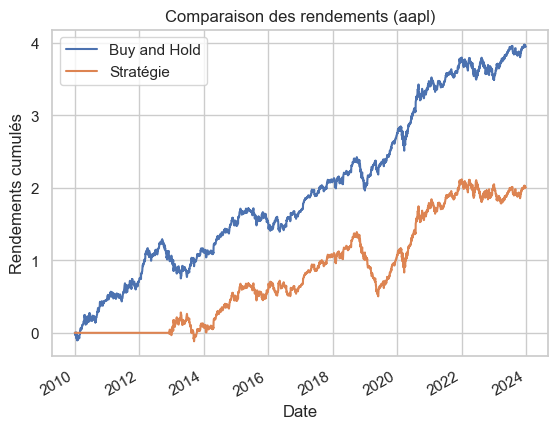

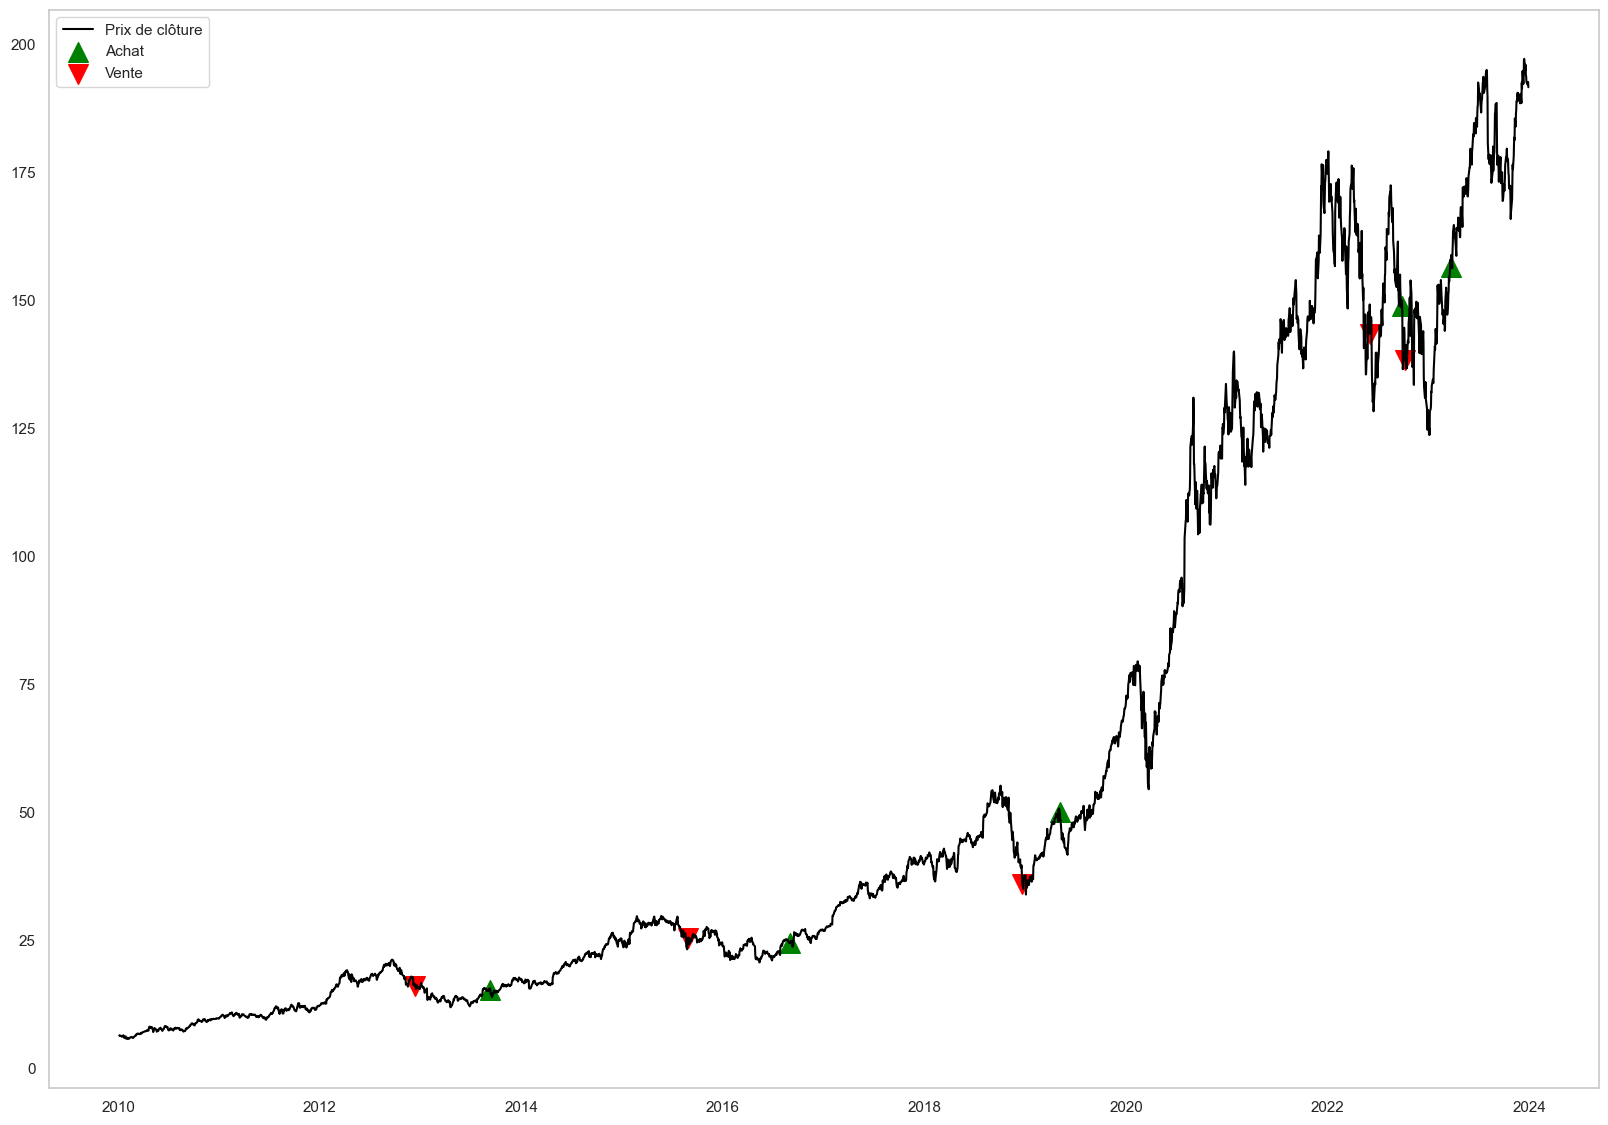

Rapport PDF généré : Rapport_Backtest_aapl_sma.pdf


In [19]:
#main pour tester backtest
def main_unique_strategie():
    # ticker
    ticker = input("Entrez le ticker (ex: ^GSPC pour S&P500, AAPL pour Apple) : ").strip()
    
    # choix dates
    choix_plage = input("Souhaitez-vous utiliser la plage par défaut (2010-2024) ? (oui/non) : ").strip().lower()
    if choix_plage == "non":
        start_date = input("Entrez la date de début (YYYY-MM-DD) : ").strip()
        end_date = input("Entrez la date de fin (YYYY-MM-DD) : ").strip()
    else:
        start_date, end_date = None, None

    # choix stratégie
    choix = input("Choisissez une stratégie : (bollinger/sma/momentum/mean reversion/sentiment) : ").strip().lower()
    if choix == "bollinger":
        strategie = bollinger
    elif choix == "sma":
        strategie = sma
    elif choix == "momentum":
        strategie = momentum
    elif choix == "mean reversion":
        strategie = mean_reversion
    elif choix == "sentiment":
        strategie = sentiment
    else:
        raise ValueError("Stratégie invalide.")
    
    # pdf ou non
    generer_pdf = input("Souhaitez-vous générer un rapport pdf ? (oui/non) : ").strip().lower() == "oui"
    
    # backtest pour une seule stratégie
    backtest(
        ticker=ticker,
        strategie=strategie,
        debut_periode=start_date,
        fin_periode=end_date,
        generer_pdf=generer_pdf
    )

if __name__ == "__main__":
    main_unique_strategie()

## III.2 Comparaison simultanée de plusieurs stratégies ##

La fonction #comp_strategies# effectue une boucle sur l'ensemble des stratégies comparées. Elle en calcule les rendements journaliers qu'elle annualise (ici on considère 252 jours de trading; attention avec certains actifs ex: crypto). On calcule ensuite les metriques de performance de chaque stratégie.

Les resultats sont présentés dans un tableau construit à l'aide du module tabulate.

On considère ici le rendement sous forme logarithmique.

In [104]:
# fonction pour comparer plusieurs stratégies
def comp_strategies(ticker, strategies, start_date=None, end_date=None):
    # plage par défaut
    if start_date is None:
        start_date = "2010-01-01"
    if end_date is None:
        end_date = "2024-01-01"

    #contexte
    print(f"Téléchargement des données pour {ticker} de {start_date} à {end_date}...")
    #on recupere la donnée sur yahoo finance
    df = yf.download(ticker, start=start_date, end=end_date)
    if df.empty:
        raise ValueError(f"Aucune donnée disponible pour {ticker} sur la période spécifiée.")

    results = {}

    for strategy_name, strategie in strategies.items():
        print(f"Application de la stratégie {strategy_name}...")
        strategy_df = strategie(df.copy())

        # calcul des rendements journaliers
        strategy_df['buy and hold'] = np.log(strategy_df['Adj Close'] / strategy_df['Adj Close'].shift(1))
        strategy_df['strategie'] = strategy_df['buy and hold'] * strategy_df['position']

        # calcul des métriques de performance
        rendement_total = f"{strategy_df['strategie'].cumsum().iloc[-1]:.2%}"
        rendement_annualisé = f"{strategy_df['strategie'].mean() * 252:.2%}"
        #volatilité annualisée : on utilise la racine carrée du nombre de jours (avec numpy)
        volatilité_annualisée = f"{strategy_df['strategie'].std() * np.sqrt(252):.2%}"
        #sharpe : rendement ajusté au risque
        sharpe_ratio = f"{(strategy_df['strategie'].mean() * 252 / (strategy_df['strategie'].std() * np.sqrt(252))):.2f}"
        #drawdown : perte maximale
        max_drawdown = f"{(strategy_df['strategie'].cumsum() - strategy_df['strategie'].cumsum().cummax()).min():.2%}"

        # sauvegarde des résultats
        results[strategy_name] = {
            "Rendement total": rendement_total,
            "Rendement annualisé": rendement_annualisé,
            "Volatilité annualisée": volatilité_annualisée,
            "Ratio de Sharpe": sharpe_ratio,
            "Drawdown maximal": max_drawdown
        }

    # affichage des résultats
    for strategy, metrics in results.items():
        print(f"\nStratégie : {strategy}")
        print(tabulate(metrics.items(), headers=["Métrique", "Valeur"], tablefmt="grid"))

    return results

Le script d'execution permet dans un premier temps de sélectionner le titre ainsi que la plage de dates testés (grande flexibilité du code). Il appelle ensuite la fonction comp_strategies et présente ses resultats.

In [18]:
#main pour comparer plusieurs strategies

def main_comparaison_strategies():
    # ticker
    ticker = input("Entrez le ticker (ex: ^GSPC pour S&P500, AAPL pour Apple) : ").strip()
    
    # choix dates
    choix_plage = input("Souhaitez-vous utiliser la plage par défaut (2010-2024) ? (oui/non) : ").strip().lower()
    if choix_plage == "non":
        start_date = input("Entrez la date de début (YYYY-MM-DD) : ").strip()
        end_date = input("Entrez la date de fin (YYYY-MM-DD) : ").strip()
    else:
        start_date, end_date = None, None

    # stratégies à comparer
    strategies = {
        "Bollinger Bands": bollinger,
        "SMA": sma,
        "Momentum": momentum,
        "Mean Reversion": mean_reversion,
        "Sentiment": sentiment
    }
    
    # comparaison
    results = comp_strategies(ticker, strategies, start_date, end_date)
    print(results)


if __name__ == "__main__":
    main_comparaison_strategies()

NameError: name 'bollinger' is not defined

Nos observations sur plusieurs titres suggèrent une faible performance des stratégies bandes de Bollinger et mean reversion, qui exhibent regulierment des rendements négatifs, et des max drawdown très importants.

On note une bonne performance des stratégies de momentum et sentiment (dans une moindre mesure), avec un rendement et ratio de Sharpe supérieurs mais aussi un max drawdown nettement inférieurs aux autres en général.

Nous avons pas pu observer de différences significatives en termes de volatilité entre les stratégies.

## III.3 Extension de la comparaison à un ensemble de tickers ##

Dans cette section, nous avons élaboré un script permettant de réaliser un backtest de toutes nos stratégies sur un ensemble de tickers de manière automatisée.

La fonction obtenir_tickers permet d'obtenir une liste de tickers dans un format exploitable à partir d'une liste html correctement formatée. Nous l'avons uniquement testé pour le S&P500 et avons obtenu un resultat satisfaisant.

Néanmoins, pour plusieurs raisons (temps, potentielle limite de requêtes api yfinance), nous avons choisi de tester notre boucle de test sur un échantillon de tickers relativement décorrélés.

In [106]:
#fonction de conversion d'un tableau html en liste python
def obtenir_tickers(url):
    #lire tableau html
    table = pd.read_html(url)
    tickers = table[0]["Symbol"].tolist()
    return tickers

# url wiki liste tickers sp500
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tickers_sp500 = obtenir_tickers(url)
print("Liste des tickers :", tickers_sp500)

#tickers_test relativement décorrélés
tickers_test = [
    "AAPL",       # Apple
    "XOM",        # ExxonMobil
    "AIR.PA",     # Airbus
    "BN.PA",      # Danone
    "BAS.DE",     # BASF (chimie, Allemagne)
    "NESN.SW",    # Nestlé
    "SAN.PA",     # Sanofi
    "VGK",        # Vanguard FTSE Europe ETF (ETF européen, large cap)
    "SPY",        # SPDR S&P 500 ETF (ETF USA, large cap)
    "GLD",        # SPDR Gold Shares (ETF or, métaux précieux)
    "EWJ"         # iShares MSCI Japan ETF (ETF Japon, diversifié)
# ]

#test tech us
# tickers_test = [
#     "AAPL",  # Apple
#     "MSFT",  # Microsoft
#     "GOOG",  # Alphabet (Google)
#     "AMZN",  # Amazon
#     "TSLA",  # Tesla
#     "NVDA",  # NVIDIA
#     "META",  # Meta Platforms
#     "AMD",   # Advanced Micro Devices
#     "INTC",  # Intel
#     "ADBE",  # Adobe
#     "CRM"    # Salesforce
# ]

#test europe
# tickers_test = [
#     "MC.PA",   # LVMH
#     "AIR.PA",  # Airbus
#     "BN.PA",   # Danone
#     "SAN.PA",  # Sanofi
#     "BAS.DE",  # BASF
#     "VOW3.DE", # Volkswagen
#     "NESN.SW", # Nestlé
#     "ASML.AS", # ASML
#     "RDSA.L",  # Shell
#     "CS.PA"    # AXA
]

Liste des tickers : ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS

La fonction comparer_strategies_loop propose de personnaliser une plage de dates. Par défaut, celle-ci est récente (2010-2024) pour s'assurer de données completes. Pour chaque ticker de la liste testée, on execute les 5 algorithmes de trading précédemment définis et on stocke les metriques de backtest dans un dataframe. Un fichier csv est également généré (pratique pour communication et analyse ultérieure).

On appelle ensuite la fonction analyse_resultats_loop. Celle ci calcule les moyennes de rendement et Sharpe pour chaque stratégie, avant de réaliser des classements selon ces critères.

Enfin, on crée un graphique représentant le ratio de Sharpe (rendement ajusté au risque) moyen de chaque stratégie de manière très intuitive.

(Le script suivant simule et analyse toutes nos stratégies de trading sur tous les tickers séléctionnés. Il prend donc quelques minutes (entre 2 et 5) d'exécution. Afin de faciliter votre appréciation, nous vous transmettons les principaux graphiques obtenus par mail)

[*********************100%%**********************]  1 of 1 completed

traitement du ticker : AAPL
Téléchargement des données pour AAPL de 2010-01-01 à 2024-01-01...
Application de la stratégie Bandes Bollinger...
Application de la stratégie Sentiment Trump...



C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1610359986.py:19: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -542.07% |
+-----------------------+----------+
| Rendement annualisé   | -38.80%  |
+-----------------------+----------+
| Volatilité annualisée | 27.97%   |
+-----------------------+----------+
| Ratio de Sharpe       | -1.39    |
+-----------------------+----------+
| Drawdown maximal      | -559.96% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 266.65%  |
+-----------------------+----------+
| Rendement annualisé   | 19.08%   |
+-----------------------+----------+
| Volatilité annualisée | 28.23%   |
+-----------------------+----------+
| Rati

[*********************100%%**********************]  1 of 1 completed
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1610359986.py:19: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


Application de la stratégie Bandes Bollinger...
Application de la stratégie Sentiment Trump...


C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -397.34% |
+-----------------------+----------+
| Rendement annualisé   | -28.44%  |
+-----------------------+----------+
| Volatilité annualisée | 25.21%   |
+-----------------------+----------+
| Ratio de Sharpe       | -1.13    |
+-----------------------+----------+
| Drawdown maximal      | -410.38% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 117.48%  |
+-----------------------+----------+
| Rendement annualisé   | 8.41%    |
+-----------------------+----------+
| Volatilité annualisée | 25.33%   |
+-----------------------+----------+
| Rati

C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -405.07% |
+-----------------------+----------+
| Rendement annualisé   | -28.50%  |
+-----------------------+----------+
| Volatilité annualisée | 34.11%   |
+-----------------------+----------+
| Ratio de Sharpe       | -0.84    |
+-----------------------+----------+
| Drawdown maximal      | -430.06% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 140.68%  |
+-----------------------+----------+
| Rendement annualisé   | 9.90%    |
+-----------------------+----------+
| Volatilité annualisée | 34.24%   |
+-----------------------+----------+
| Rati

C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -264.27% |
+-----------------------+----------+
| Rendement annualisé   | -18.59%  |
+-----------------------+----------+
| Volatilité annualisée | 19.71%   |
+-----------------------+----------+
| Ratio de Sharpe       | -0.94    |
+-----------------------+----------+
| Drawdown maximal      | -282.79% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 39.93%   |
+-----------------------+----------+
| Rendement annualisé   | 2.81%    |
+-----------------------+----------+
| Volatilité annualisée | 19.79%   |
+-----------------------+----------+
| Rati

C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -416.62% |
+-----------------------+----------+
| Rendement annualisé   | -29.52%  |
+-----------------------+----------+
| Volatilité annualisée | 26.48%   |
+-----------------------+----------+
| Ratio de Sharpe       | -1.11    |
+-----------------------+----------+
| Drawdown maximal      | -417.35% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 73.35%   |
+-----------------------+----------+
| Rendement annualisé   | 5.20%    |
+-----------------------+----------+
| Volatilité annualisée | 26.68%   |
+-----------------------+----------+
| Rati

C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -138.85% |
+-----------------------+----------+
| Rendement annualisé   | -9.94%   |
+-----------------------+----------+
| Volatilité annualisée | 15.36%   |
+-----------------------+----------+
| Ratio de Sharpe       | -0.65    |
+-----------------------+----------+
| Drawdown maximal      | -142.74% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 66.19%   |
+-----------------------+----------+
| Rendement annualisé   | 4.74%    |
+-----------------------+----------+
| Volatilité annualisée | 15.48%   |
+-----------------------+----------+
| Rati

C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -347.14% |
+-----------------------+----------+
| Rendement annualisé   | -24.42%  |
+-----------------------+----------+
| Volatilité annualisée | 22.26%   |
+-----------------------+----------+
| Ratio de Sharpe       | -1.10    |
+-----------------------+----------+
| Drawdown maximal      | -350.49% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 35.34%   |
+-----------------------+----------+
| Rendement annualisé   | 2.49%    |
+-----------------------+----------+
| Volatilité annualisée | 22.43%   |
+-----------------------+----------+
| Rati

[*********************100%%**********************]  1 of 1 completed
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1610359986.py:19: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


Application de la stratégie Bandes Bollinger...
Application de la stratégie Sentiment Trump...


C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -264.52% |
+-----------------------+----------+
| Rendement annualisé   | -18.93%  |
+-----------------------+----------+
| Volatilité annualisée | 21.28%   |
+-----------------------+----------+
| Ratio de Sharpe       | -0.89    |
+-----------------------+----------+
| Drawdown maximal      | -265.11% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 105.86%  |
+-----------------------+----------+
| Rendement annualisé   | 7.58%    |
+-----------------------+----------+
| Volatilité annualisée | 21.52%   |
+-----------------------+----------+
| Rati

[*********************100%%**********************]  1 of 1 completed
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1610359986.py:19: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


Application de la stratégie Bandes Bollinger...
Application de la stratégie Sentiment Trump...


C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -83.76%  |
+-----------------------+----------+
| Rendement annualisé   | -5.99%   |
+-----------------------+----------+
| Volatilité annualisée | 17.29%   |
+-----------------------+----------+
| Ratio de Sharpe       | -0.35    |
+-----------------------+----------+
| Drawdown maximal      | -93.42%  |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 159.66%  |
+-----------------------+----------+
| Rendement annualisé   | 11.43%   |
+-----------------------+----------+
| Volatilité annualisée | 17.38%   |
+-----------------------+----------+
| Rati

[*********************100%%**********************]  1 of 1 completed
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1610359986.py:19: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


Application de la stratégie Bandes Bollinger...
Application de la stratégie Sentiment Trump...


C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -190.89% |
+-----------------------+----------+
| Rendement annualisé   | -13.66%  |
+-----------------------+----------+
| Volatilité annualisée | 15.37%   |
+-----------------------+----------+
| Ratio de Sharpe       | -0.89    |
+-----------------------+----------+
| Drawdown maximal      | -194.71% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 80.08%   |
+-----------------------+----------+
| Rendement annualisé   | 5.73%    |
+-----------------------+----------+
| Volatilité annualisée | 15.56%   |
+-----------------------+----------+
| Rati

[*********************100%%**********************]  1 of 1 completed
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1610359986.py:19: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


Application de la stratégie Bandes Bollinger...
Application de la stratégie Sentiment Trump...


C:\Users\odend\AppData\Local\Temp\ipykernel_14904\1150360562.py:42: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\3535764061.py:18: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\323168906.py:16: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\odend\AppData\Local\Temp\ipykernel_14904\2865962126.py:15: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0,

Application de la stratégie Mean Reversion...
Application de la stratégie SMA...
Application de la stratégie Momentum...

Stratégie : Bandes Bollinger
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | -229.24% |
+-----------------------+----------+
| Rendement annualisé   | -16.41%  |
+-----------------------+----------+
| Volatilité annualisée | 17.55%   |
+-----------------------+----------+
| Ratio de Sharpe       | -0.93    |
+-----------------------+----------+
| Drawdown maximal      | -229.53% |
+-----------------------+----------+

Stratégie : Sentiment Trump
+-----------------------+----------+
| Métrique              | Valeur   |
+=======================+==========+
| Rendement total       | 67.11%   |
+-----------------------+----------+
| Rendement annualisé   | 4.80%    |
+-----------------------+----------+
| Volatilité annualisée | 17.65%   |
+-----------------------+----------+
| Rati

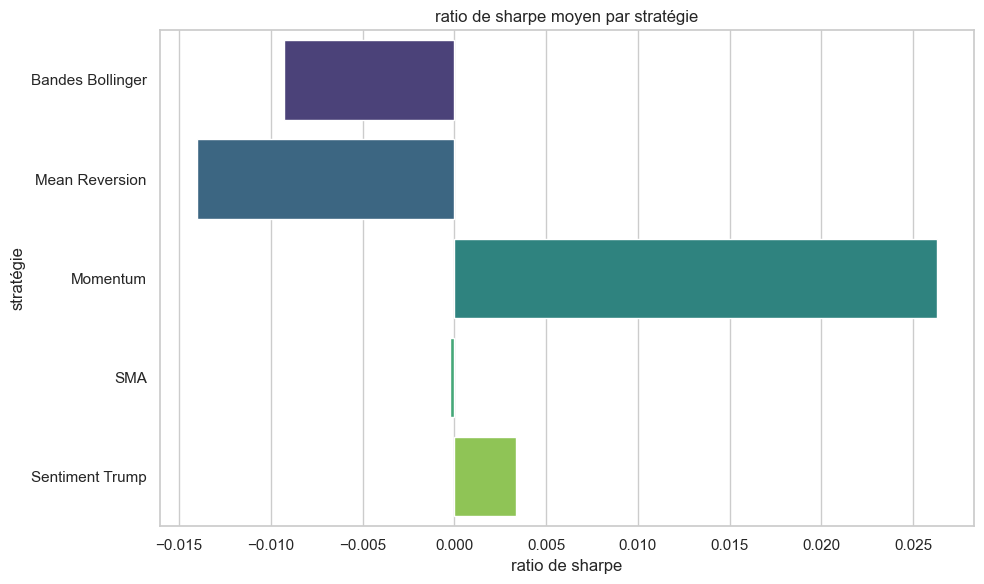

In [107]:
# fonction principale pour comparer les stratégies
def comparer_strategies_loop(tickers):
    # demander la plage de dates
    choix_plage = input("souhaitez-vous utiliser la plage par défaut (2010-2024) ? (oui/non) : ").strip().lower()
    if choix_plage == "non":
        date_debut = input("entrez la date de début (YYYY-MM-DD) : ").strip()
        date_fin = input("entrez la date de fin (YYYY-MM-DD) : ").strip()
    else:
        date_debut, date_fin = None, None

    # définir les stratégies
    strategies = {
        "Bandes Bollinger": bollinger,
        "Sentiment Trump": sentiment,
        "Mean Reversion": mean_reversion,
        "SMA": sma,
        "Momentum": momentum,
    }

    # initialisation du df pour stocker tous les resultats
    tous_resultats = []

    # comparer les stratégies pour chaque ticker
    for ticker in tickers:
        print(f"traitement du ticker : {ticker}")
        try:
            resultats = comp_strategies(ticker, strategies, date_debut, date_fin)

            # resultats en format df
            for strategie, metriques in resultats.items():
                metriques["strategie"] = strategie
                metriques["ticker"] = ticker
                tous_resultats.append(metriques)
        #gestion erreur
        except Exception as e:
            print(f"erreur lors du traitement du ticker {ticker} : {e}")

    # combinaison des resultats en un seul df
    df_resultats = pd.DataFrame(tous_resultats)

    # sauvegarde dans un csv pour analyse ultérieure
    df_resultats.to_csv("resultats_comparaison_strategies.csv", index=False)
    print("'resultats_comparaison_strategies.csv'")

    # analyser et résumer les résultats
    analyse_resultats_loop(df_resultats)

# fonction pour analyser et résumer les résultats
def analyse_resultats_loop(df_resultats):
    # conversion des colonnes numériques (suppression des % et conversion en float)
    for col in ["Rendement total", "Rendement annualisé", "Volatilité annualisée", "Ratio de Sharpe", "Drawdown maximal"]:
        df_resultats[col] = df_resultats[col].str.rstrip("%").astype(float) / 100

    # calcul des moyennes et des classements pour chaque stratégie
    resume_strategies = df_resultats.groupby("strategie").agg(
        {
            "Rendement total": "mean",
            "Rendement annualisé": "mean",
            "Volatilité annualisée": "mean",
            "Ratio de Sharpe": "mean",
            "Drawdown maximal": "mean",
        }
    ).reset_index()

    # ajouter des colonnes de classement
    resume_strategies["classement_sharpe"] = resume_strategies["Ratio de Sharpe"].rank(ascending=False)
    resume_strategies["classement_rendement"] = resume_strategies["Rendement annualisé"].rank(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Ratio de Sharpe", y="strategie", data=resume_strategies, palette="viridis")
    plt.title("ratio de sharpe moyen par stratégie")
    plt.xlabel("ratio de sharpe")
    plt.ylabel("stratégie")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    comparer_strategies_loop(tickers_test)

Le graphique fourni par le test de notre stratégie sur un échantillon de titres diversifiés (ainsi que la tech us et quelques européens) suggère une meilleure performance de la stratégie Momentum. En effet, elle présente un ratio de Sharpe moyen nettement supérieur aux autres. 

Suite à cet ensemble de backtests, on privilégie donc la stratégie Momentum.

On observe que les bandes de Bollinger et Mean Reversion présentent sur nos tests un ratio de Sharpe négatif, donc un rendement inférieur à 0. Cette performance est très mauvaise surtout sachant que le S&P500 a présenté un rendement annuel moyen de 12.6% sur la même période (2010-2024, statmuse.com).